<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#分析" data-toc-modified-id="分析-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>分析</a></span><ul class="toc-item"><li><span><a href="#分词" data-toc-modified-id="分词-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>分词</a></span></li><li><span><a href="#描述统计部分" data-toc-modified-id="描述统计部分-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>描述统计部分</a></span></li><li><span><a href="#基于词典的情感浓度计算" data-toc-modified-id="基于词典的情感浓度计算-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>基于词典的情感浓度计算</a></span></li></ul></li><li><span><a href="#主题模型-情感词典" data-toc-modified-id="主题模型-情感词典-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>主题模型-情感词典</a></span><ul class="toc-item"><li><span><a href="#NMF模型" data-toc-modified-id="NMF模型-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>NMF模型</a></span></li><li><span><a href="#LDA模型" data-toc-modified-id="LDA模型-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LDA模型</a></span></li><li><span><a href="#100分类LDA模型" data-toc-modified-id="100分类LDA模型-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>100分类LDA模型</a></span></li></ul></li><li><span><a href="#构建新词表" data-toc-modified-id="构建新词表-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>构建新词表</a></span></li></ul></div>

In [2]:
import pandas as pd

In [5]:
# 原始数据拼起来
df1 = pd.read_json('lyrics1.json')
df2 = pd.read_json('lyrics2.json')
df3 = pd.read_json('lyrics3.json')
df4 = pd.read_json('lyrics4.json')
df5 = pd.read_json('lyrics5.json')
df = pd.concat([df1,df2,df3,df4,df5])

df

,name,singer,lyric
0,《Young and dream》原创吉他弹唱demo,郑冰冰,"[《少年与梦》G调, 作曲 郑冰冰, 演唱 郑冰冰, , 主歌1, 有一天我从座位的窗口望下..."
1,风雨里 demo,郑冰冰,"[风雨里, 作词 白以白, 作曲 郑冰冰, 编曲 彭扬, 演唱 郑冰冰, 和声 郑冰冰, 后..."
2,吉他弹唱demo 别让我在你背后哭 升D调,郑冰冰,"[别让我在你背后哭 升D调, , 主歌1, 冷冷地望着眼前这一幕, 无所谓还在不在乎, 你的..."
3,静夜思2018,郑冰冰,"[《静夜思2018》, 作词 李白&白以白, 作曲 郑冰冰, 编曲 王铁辉, 演唱 郑冰冰,..."
4,弹唱demo 海子《面朝大海春暖花开》,郑冰冰,"[面朝大海，春暖花开 G调, 作词 海子, 作曲 郑冰冰, 吉他弹唱 郑冰冰, , 主歌1,..."
...,...,...,...
22192,男人花,黄勇山野,"[当保护你的她, 变成要你保护的她, 当你远离了家, 努力有了你爱的她, 突然发现那个, 爱..."
22193,心碎了哭什么哭,欧阳清风,"[弹琴吧唱歌吧跳舞吧 视线中只有你我, 开心过伤心过疯狂过 风雨里一起走过, 失业了失恋了迷..."
22194,慢慢飞,付曼,"[, 突然间有些难为, 就连呼吸都感觉好累, 我看不见 你的所谓, 所谓幸福的描绘, 闭上眼..."
22195,知何音,何爽冰,"[, 雁去留冬窗晓初透, 闻声 过船头, 醒时才知雨疏夜漏, 不语 听琴奏, 几声秋, 恍若..."


In [6]:
import pickle
pickle.dump(df,open('lyric.pkl','wb'))

## 分析

In [209]:
import pandas as pd
import numpy as np
import jieba
import re
import zhconv
from time import time
import pickle
import itertools

# 词云
from wordcloud import WordCloud
from itertools import chain
import wordcloud
# 画图
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import codecs
from datetime import datetime
from gensim import corpora, models
import math

In [342]:
df = pd.read_pickle('lyric.pkl')
df.reset_index(inplace = True,drop = True)
df.head()

,name,singer,lyric
0,《Young and dream》原创吉他弹唱demo,郑冰冰,"[《少年与梦》G调, 作曲 郑冰冰, 演唱 郑冰冰, , 主歌1, 有一天我从座位的窗口望下..."
1,风雨里 demo,郑冰冰,"[风雨里, 作词 白以白, 作曲 郑冰冰, 编曲 彭扬, 演唱 郑冰冰, 和声 郑冰冰, 后..."
2,吉他弹唱demo 别让我在你背后哭 升D调,郑冰冰,"[别让我在你背后哭 升D调, , 主歌1, 冷冷地望着眼前这一幕, 无所谓还在不在乎, 你的..."
3,静夜思2018,郑冰冰,"[《静夜思2018》, 作词 李白&白以白, 作曲 郑冰冰, 编曲 王铁辉, 演唱 郑冰冰,..."
4,弹唱demo 海子《面朝大海春暖花开》,郑冰冰,"[面朝大海，春暖花开 G调, 作词 海子, 作曲 郑冰冰, 吉他弹唱 郑冰冰, , 主歌1,..."


In [3]:
# tokenized_corpus = pd.read_pickle('data/lyc_tokenized_corpus.pkl')
# tokenized_corpus

In [3]:
# from functools import partial
# import re

# def remove_special_characters(text, pattern):
#     filtered_text = re.sub(pattern, '', text)
#     return filtered_text

# PATTERN = '[ |,|\n|【|】|——|“|”|%|（|）|《|》]'
# remove = partial(remove_special_characters, pattern=PATTERN)
# lyric1 = df['lyric'].apply(remove)
# lyric1

In [3]:
df['lyric'][0]

0    [《少年与梦》G调, 作曲 郑冰冰, 演唱 郑冰冰, , 主歌1, 有一天我从座位的窗口望下...
0    [深情的人在夜里扬着脸, 星光闪烁在天边, 耳语喧哗在不眠树影间, 灵魂游走夜的边缘, 风中...
0    [无情人偏偏拢是拗人, 欲走的时存未留恋, 伊的心未交乎别人, 尚多是留一鬃, 伊美丽的头鬃...
0    [恰似你的温柔, , 某年某月的某一天, 就象一张破碎的脸, 难以开口道再见, 就让一切走远...
0    [郑伊健     >, , 消失的光阴散在风里, 仿佛想不起再面对, 流浪日子, 你在伴随,...
Name: lyric, dtype: object

In [67]:
len(df['lyric'])

102197

In [32]:
np.array(set(df['singer']))

array({'郑吟秋', '桂莹莹', '零点', '澎恰恰', '朱星杰', '白雅彤', '田宇杨子', '芮甜甜', '方锦龙', '那英小柯', '李汶峰', '未来星', '狄易达', '刁寒', '李丽芬', '西楼', '许嵩黄龄', '齐豫', '傅颖', '吉克媛媛', '林志美', '光良卫兰', '包朝克', '晓华', '傅天颖', '任宇翔', '桂纶镁', '杨臣刚', '阿木', '雅旭', '灰色', '阿信黄渤', '李维', '秋秋', '木小雅', 'Fran', '梅艳芳', '好事花生', '徐良杨威', '贯诗钦', '青蛙乐队', '雷子', '平安', '尚雯婕', '高胜美', '方季惟', '岳云鹏', '传琦', '谢和弦', '傲日其愣', '叶倩文', '卞留念', '演奏曲', '杨坤黄渤', '郭浩男', '汪琨', '王思远', '孟杨', '那英刘欢', '姚苏蓉', '洪雨雷', '王百合', '郭顶', 'YK-D', '潘新明', '周毅', '李鑫玲', '彭宇', '玫子', '单色凌', '沈煜伦', '唐艾萱', '鄧麗君', '韩安旭', '甘仕良', '齐一', '新疆群星', '白芳菲', '雷安娜', '南湘', '郑丽丝', '徐良本兮', '艾梦萌', '王熠熠', '心华', '张栋梁', '徐圣恩', '左麟右李', '龙梅子', 'Veda', '边巴德吉', '易烊千玺', '水月', '张继聪', '甄秀珍', '倪纯', '倾夜临川', '张杰谭晶', '欧阳铭芮', '陈秋含', '陈鹏杰', '陈琳杨坤', '麦琪夏禾', '罗家英', '索朗扎西', '林依轮', 'G.G', '习谱予', '王二妮', '陶峻汐', '付浩天', '屠颖', '居里里', '田震小柯', '高丽馥', '北岛诗', '前男友', '塔斯肯', '关诗敏', '枫宇辰', '何静方磊', '欧阳曹亮', '孙楠', '老钱', '牛帛媛', '苏芮', '王福海', '池年核桃', '东浩', '倪睿思', '王宁', '赵洳顺', '想想君洛', '贝歌', '官灵芝', '可可薇娜', '唐荭菲', '曹方', '陈伟伦', '鲍蕙荞', '珊瑚', '赤飯', '小

### 分词

In [128]:
def line_cut(text):
    """单句分词
    text为单个字符串
    """
    if text:
        tokens = jieba.cut(text)
        filtered_tokens = [str(word) for word in tokens if word not in stopwords] # 加入停用词限制
        return filtered_tokens
    else:
        return []

def remove_special_characters(text):
    """删除特殊字符
    Parameters
    ----------
    text : 字符串
    pattern : 要删除的特殊字符形式
    """
    pattern = '[\n|【|】|——|“|”|%|（|）|《|》|，|。]'
    text = re.sub('[^\u4e00-\u9fa5]+','',text)
    
    #text = zhconv.convert(text, 'zh-cn') # 繁体转换，会让程序显著变慢，只在分词时候用一下
    filtered_text = re.sub(pattern, '', text)
     
    return filtered_text


def song_cut(song):
    """
        input一首歌【Series格式】，删去特殊字符与空字符串，并且每行歌词都转化为分词list的形式，最终输出array
    """
    if type(song) == 'pandas.core.series.Series':
        song = song.tolist()[0]
    filtered_text = list(filter(lambda s:s and s.strip(),song))
    
    new_line = list(map(remove_special_characters,filtered_text))
    song_token = list(map(line_cut,new_line))
    return song_token


def tokenline(song):
    """输出一首歌歌词分词后的全部词"""
    lista = []
    cut = song_cut(song)
    for line in cut:
        if line:
            lista.extend(line)
        else:
            pass
    if not lista:
        return [' ']
    else:
        return lista
    
# 停用词
stopwords = []
with open('cn_stopwords.txt', 'r', encoding='utf-8') as file:
    while True:
        line = file.readline().replace('\n', '')
        if not line:
            break
        else:
            stopwords.append(line)

blacklist = ['你','会','说','一个','里','想','中','没','走','做','不会','不能','不再','太','更','总是','也许','知道',
            '最后','我会','你说','我要','你是','今天','给你','带','讲','我在','便','唔','回','我的']
stopwords.extend(blacklist)


# user_dict
jieba.load_userdict("E:/jupyterdir/jupyter_dir/深度学习/文本分析/dict/hownet/负面评价词语（中文）.txt")
jieba.load_userdict("E:/jupyterdir/jupyter_dir/深度学习/文本分析/dict/hownet/负面情感词语（中文）.txt")
jieba.load_userdict("E:/jupyterdir/jupyter_dir/深度学习/文本分析/dict/hownet/正面评价词语（中文）.txt")
jieba.load_userdict("E:/jupyterdir/jupyter_dir/深度学习/文本分析/dict/hownet/正面情感词语（中文）.txt")


# 把歌手的名字以及歌曲名加入用户词
newwords = df['singer'].values.tolist()
for word in newwords:
    jieba.add_word(word,100000)
newwords = df['name'].values.tolist()
for word in newwords:
    jieba.add_word(word,100000)

    
def cut_all_kw(data):
    """分全部的词
    data: 全部的词，Series形式
    """
    token_all = []
    
    for data_line in data.values:
        name = data_line[0]
        singer = data_line[1]
        temp = tokenline(data_line[2])
        if temp:
            token_all.append((name,singer,temp))
        else:
            pass
        
    return token_all

In [5]:
song_cut(df[df['name']=='烟火里的尘埃']['lyric'].tolist()[0])

[['看着', '飞舞', '尘埃', '掉下来'],
 ['没人', '发现', '存在'],
 ['自由自在'],
 ['世界', '爱', '热热闹闹'],
 ['容不下', '百无聊赖'],
 ['不应该', '一个人', '发呆'],
 ['只有我', '守', '安静', '沙漠'],
 ['等待', '花开'],
 ['只有我', '看着', '快乐'],
 ['竟然', '会', '感慨'],
 ['就让', '听着', '天大', '道理'],
 ['不愿意', '明白'],
 ['应该不应该'],
 ['我的心', '里', '住', '一个'],
 ['苍老', '小孩'],
 ['世界', '听不明白'],
 ['影子', '表白'],
 ['是不是', '只有我', '问'],
 ['明天', '更', '精彩'],
 ['烟火', '里', '找不到', '童真', '残骸'],
 ['只有我', '守', '安静', '沙漠'],
 ['等待', '花开'],
 ['只有我', '看着', '快乐'],
 ['竟然', '会', '感慨'],
 ['就让', '听着', '天大', '道理'],
 ['不愿意', '明白'],
 ['只有我', '就是我'],
 ['奇怪', '感慨'],
 ['风', '阵阵', '吹过来', '回来'],
 ['风', '一去不回', '悲', '悲哀'],
 ['麻木', '快', '应不应该'],
 ['能不能', '慢下来'],
 ['笑', '开怀', '哭', '坦率'],
 ['表情', '这世界', '安排'],
 ['我就是我', '是我'],
 ['一场', '烟火', '散落', '尘埃'],
 ['风', '阵阵', '吹过来'],
 ['风', '一去不回'],
 ['能不能', '慢下来']]

In [190]:
for lines in df.values:
    print(lines)
    break

['《Young\xa0and\xa0dream》原创吉他弹唱demo' '郑冰冰'
 list(['《少年与梦》G调', '作曲 郑冰冰', '演唱 郑冰冰', '', '主歌1', '有一天我从座位的窗口望下去，', '看见一群入职的新同学，', '他们的笑脸天真又充满期许，', '一瞬间想起了那时候的自己。', '', '主歌2', '在创业大厦戴上工牌的那一天起，', '我的人生好像改变了轨迹，', '那些尘世中的苟且与卑离，', '已经慢慢离我远去。', '', '过渡', '虽然还是会有不开心的故事，', '虽然迷惘也会偶尔的来袭，', '但这是一个真实的地方，', '还有一群人让你无所畏惧。', '', '副歌1', '梦想你好吗 不知不觉十八年', '梦想你还记得吗 那群小小的少年', '曾经我们在湖畔许下的誓言，', '到今天，到永远，也不会改变', '', '副歌2', '梦想你好吗 也许再过很多年', '梦想你还记得呀 这群追梦的少年', '曾经我们在湖畔许下的誓言，', '到今天，到永远，也不会改变', '', '间奏', '', '主歌3', '第一次在阿里大声哭泣，', '你们递过来纸巾和双臂，', '你们说怕什么有我们在一起，', '就像候鸟成群翱翔在天际。', '', '主歌4', '百阿的片段像电影一样想起，', '内网的标签又被贴满了一地，', '我也羡慕我那从不加班的弟弟，', '但我更爱五年陈的时候有我也有你。', '', '过渡2', '生命就像是一个一个誓言', '既要用力嘶吼也要温柔兑现', '别人看来我们已经站在了山巅', '但我们却更加向往彩虹和云间', '', '', '副歌 啦啦啦大合唱', '', '结尾', '我爱你 阿里巴巴（爸爸）', ''])]


In [129]:
# 对所有歌曲分词
tokenized_corpus_temp = cut_all_kw(df.dropna())#.reset_index(drop = True,inplace = True)
# tokenized_corpus_temp[0]
tokenized_corpus = [lyric[2] for lyric in tokenized_corpus_temp]
tokenized_corpus[0]

['少年与梦',
 '调',
 '作曲',
 '郑冰冰',
 '演唱',
 '郑冰冰',
 '主歌',
 '有一天',
 '座位',
 '窗口',
 '下去',
 '看见',
 '一群',
 '入职',
 '新',
 '同学',
 '笑脸',
 '天真',
 '充满',
 '期许',
 '一瞬间',
 '想起',
 '那时候',
 '主歌',
 '创业',
 '大厦',
 '戴',
 '上工',
 '牌',
 '那一天',
 '人生',
 '好像',
 '改变',
 '轨迹',
 '尘世',
 '苟且',
 '卑离',
 '已经',
 '慢慢',
 '远去',
 '过渡',
 '开心',
 '故事',
 '迷惘',
 '偶尔',
 '袭',
 '真实',
 '地方',
 '一群',
 '无所畏惧',
 '副歌',
 '梦想',
 '你好吗',
 '不知不觉',
 '十八年',
 '梦想',
 '你还记得吗',
 '那群',
 '小小的',
 '少年',
 '曾经',
 '湖畔',
 '许下',
 '誓言',
 '今天到永远',
 '不会改变',
 '副歌',
 '梦想',
 '你好吗',
 '再过',
 '很多年',
 '梦想',
 '还记得',
 '这群',
 '追梦的少年',
 '曾经',
 '湖畔',
 '许下',
 '誓言',
 '今天到永远',
 '不会改变',
 '间奏',
 '主歌',
 '第一次',
 '阿里',
 '大声',
 '哭泣',
 '你们',
 '递过来',
 '纸巾',
 '双臂',
 '你们',
 '怕什么',
 '我们在一起',
 '候鸟',
 '成群',
 '翱翔',
 '天际',
 '主歌',
 '百阿',
 '片段',
 '电影',
 '想起',
 '内网',
 '标签',
 '贴',
 '满',
 '一地',
 '羡慕我',
 '从不',
 '加班',
 '弟弟',
 '更爱',
 '五年',
 '陈',
 '有你',
 '过渡',
 '生命',
 '像是',
 '誓言',
 '既要',
 '用力',
 '嘶吼',
 '温柔',
 '兑现',
 '看来',
 '已经',
 '站',
 '山巅',
 '更加',
 '向往',
 '彩虹',
 '云间',
 '副歌',
 '啦啦啦',
 '大合唱',
 '结尾',
 '我爱你',

In [130]:
# 保存分词后数据
# pickle.dump(tokenized_corpus_temp,open('data/lyc_tokenized_corpus_temp_zh_stop.pkl','wb'))
# pickle.dump(tokenized_corpus,open('data/lyc_tokenized_corpus_zh_stop.pkl','wb'))

In [4]:
tokenized_corpus_temp = pd.read_pickle('data/lyc_tokenized_corpus_temp_zh_stop.pkl')
tokenized_corpus = pd.read_pickle('data/lyc_tokenized_corpus_zh_stop.pkl')

In [131]:
# 全文非中文的歌词数量
space = pd.Series(tokenized_corpus_temp)[pd.Series(tokenized_corpus_temp).str[0] == 'Why Nobody Fights'][74476][2]
print(space)
sum(pd.Series(tokenized_corpus_temp).str[2].str[0] == ' ')

[' ']


3004

In [132]:
def words_freq_stat(text_token_all):
    """将所有分好的词连起来，放在一起计算词频"""
    words_all_raw = []
    for i in text_token_all:
        words_all_raw.extend(i)
        
    words_all = list(set(words_all_raw))
    words_freq = pd.Series(words_all_raw).value_counts()
    return words_freq, words_all

words_freq, words_all = words_freq_stat(tokenized_corpus)

In [5]:
len(words_all)

283361

In [188]:
type(tokenized_corpus)

list

In [126]:
words_freq[:100].index

Index(['我的', '爱', '没有', '心', '永远', '为你', '爱情', '世界', '不要', '已经', '是你', '寂寞',
       '幸福', '梦', '是我', '时间', '我的心', '美丽', '快乐', '给我', '笑', '回忆', '心里', '一起',
       '曾经', '感觉', '心中', '现在', '真的', '太多', '温柔', '希望', '生活', '一生', '不想', '是否',
       '一直', '需要', '爱你', '你我', '过去', '唱', '未来', '听', '眼泪', '我想', '生命', '一个人',
       '情', '等待', '孤单', '留下', '思念', '天空', '无法', '离开', '一点', '请', '变成', '能够',
       '人生', '身边', '我不', '忘记', '温暖', '想要', '怕', '明白', '失去', '明天', '拥抱', '感情',
       '泪', '哭', '风', '想起', '喜欢', '不知', '和你', '请你', '拥有', '孤独', '其实', '路',
       '梦想', '手', '自由', '一种', '每个', '有你', '改变', '我就', '记忆', '伤心', '愿', '依然',
       '岁月', '不必', '微笑', '快'],
      dtype='object')

### 描述统计部分

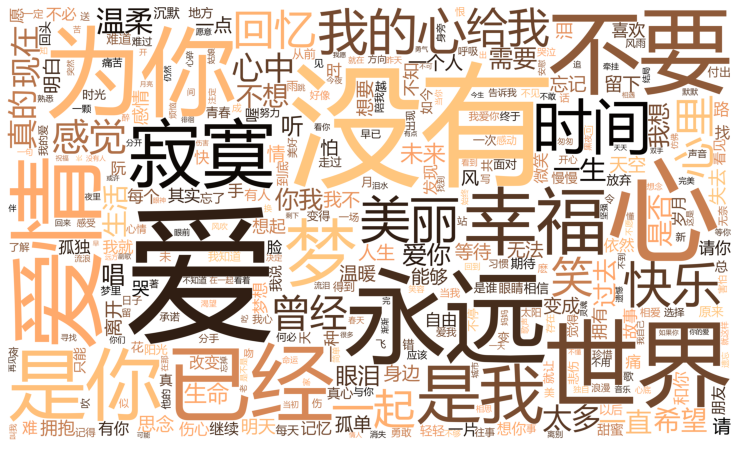

In [195]:
## 画个简单的词云
# from wordcloud import WordCloud
# from itertools import chain

def lyric_wordcloud(image=None, not_show=None):
    my_wordcloud = wordcloud.WordCloud(scale=4,
                                       #font_path=font,
                                       mask=image,
                                       stopwords=not_show,
                                       background_color='white',
                                       font_path="msyh.ttc",
                                       collocations= False,
                                       colormap="copper",  #自定义构建colormap对象
                                       margin=3,                          #词云图边距
                                       max_font_size = 200,               #显示的最大的字体大小
                                       max_words=350,                     # 设置最大显示的字数 
                                       #min_font_size = 10,               #显示的最小的字体大小
                                       width=1000,                        #词云图宽度
                                       height=600,                        #词云图高度
                                       random_state=322)
    return my_wordcloud


cloudwords = " ".join(list(chain.from_iterable(tokenized_corpus)))
wc = lyric_wordcloud().generate(cloudwords)
#显示图片
plt.figure(figsize=(13,20))
plt.imshow(wc)
plt.axis('off')        #关闭坐标
plt.show()

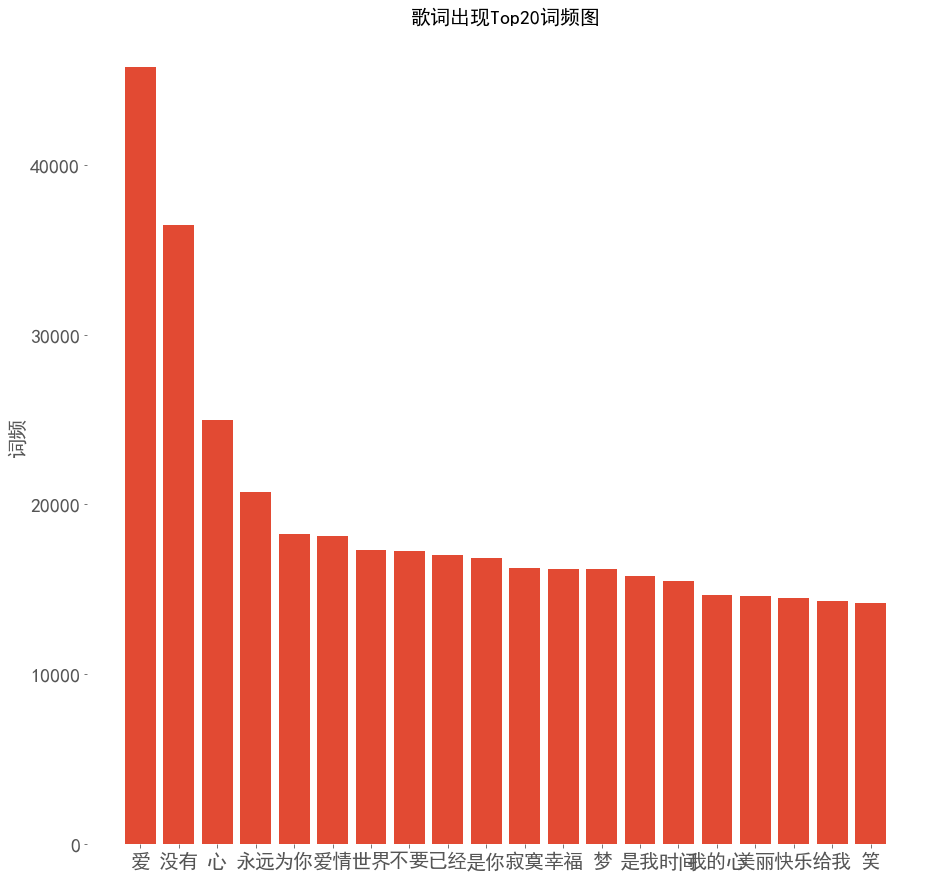

In [194]:
# 词频统计
freq_df = pd.DataFrame(words_freq,columns = ['词频'])
freq_df.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15,15))

plt.bar(list(freq_df['index'][:20].values),freq_df['词频'][:20])
plt.title('歌词出现Top20词频图', fontsize=20)
plt.style.use('ggplot')

plt.box(False)  #不显示四周边框线

plt.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.grid(which='both', linewidth=0.5)
plt.xlabel('')
plt.ylabel('词频', fontsize=20)
plt.show()


In [210]:
def kw_exist(text_token):
    """计算各种关键词是否在歌曲中存在
    范围：全部歌曲
    """
    artificial_kw = [0]*20
    idx = dict(list(zip(freq_df['index'][:20],range(20))))
    
    for song in text_token:
        for kw in list(idx.keys()):
            if kw in song:
                artificial_kw[idx[kw]] += 1

    return artificial_kw


def co_exist(text_token):
    """计算单词交互/共现情况"""
    dat_exist = [] # 得分array
    for i in text_token:
        dat_exist.append(kw_exist(i))

    col = freq_df['index'][:20]
    dat2 = pd.DataFrame(dat_exist,columns = col)

    upd = pd.DataFrame(list(map(list,dat2.value_counts().index.values.tolist())),columns = col)
    upd['频数'] = dat2.value_counts().values

    zero = pd.DataFrame(np.array([0,0,0,0,0,0,0,0,0,0,
                                  0,0,0,0,0,0,0,0,0,0]*20).reshape(20,20),columns = col,index = col)
    for lista in itertools.permutations(col,2):
        zero[lista[0]][lista[1]] = upd['频数'][upd[lista[0]]==1][upd[lista[1]]==1].sum()
    return dat2,zero

In [211]:
dat2,zero = co_exist(tokenized_corpus)
zero

index,爱,没有,心,永远,为你,爱情,世界,不要,已经,是你,寂寞,幸福,梦,是我,时间,我的心,美丽,快乐,给我,笑
index,,,,,,,,,,,,,,,,,,,,
爱,0,1431,2420,871,662,1008,1097,658,691,658,717,640,1698,828,723,529,679,737,528,1821
没有,1431,0,1799,785,571,699,1121,654,738,742,707,556,1272,918,796,537,582,655,571,1389
心,2420,1799,0,1076,774,810,1459,879,827,882,945,829,2283,1054,992,801,872,958,653,2293
永远,871,785,1076,0,402,405,689,358,392,420,407,452,818,475,511,316,362,420,334,855
为你,662,571,774,402,0,327,455,317,331,411,290,277,608,462,325,305,266,334,290,701
爱情,1008,699,810,405,327,0,462,300,348,349,381,388,614,402,393,260,324,329,239,648
世界,1097,1121,1459,689,455,462,0,503,470,509,515,539,1080,634,702,378,471,606,387,1209
不要,658,654,879,358,317,300,503,0,388,375,336,266,585,404,391,252,213,341,325,685
已经,691,738,827,392,331,348,470,388,0,366,343,277,632,454,441,282,241,321,283,665


In [212]:
zero.to_excel('top20词语共现矩阵.xlsx')

### 基于词典的情感浓度计算

In [213]:
### HowNet
# 把情感词表存成array
nagtive_judge = pd.read_table('E:/jupyterdir/jupyter_dir/深度学习/文本分析/dict/hownet/负面评价词语（中文）.txt',header=None)[0].values
nagtive_emotion = pd.read_table('E:/jupyterdir/jupyter_dir/深度学习/文本分析/dict/hownet/负面情感词语（中文）.txt',header=None)[0].values
positive_judge = pd.read_table('E:/jupyterdir/jupyter_dir/深度学习/文本分析/dict/hownet/正面评价词语（中文）.txt',header=None)[0].values
positive_emotion = pd.read_table('E:/jupyterdir/jupyter_dir/深度学习/文本分析/dict/hownet/正面情感词语（中文）.txt',header=None)[0].values
positive_emotion

array(['噲', '媢', '媢嫉', '忺', '爱', '爱不忍释', '爱不释手', '爱宠', '爱戴', '爱抚', '爱好',
       '爱护', '爱怜', '爱恋', '爱慕', '爱上', '爱屋及乌', '爱惜', '安', '昂扬', '巴', '巴不得',
       '巴望', '摆好', '拜', '拜拜', '拜服', '拜贺', '拜谒', '褒', '褒奖', '褒扬', '睎',
       '表扬', '表彰', '并重', '补台', '不看僧面看佛面', '不愧', '不胜欣忭', '不惜', '不厌', '睬',
       '采纳', '参拜', '参谒', '侧重', '馋', '畅快', '唱喏', '倡', '朝拜', '朝思暮想', '撑台面',
       '撑腰', '称', '称道', '称快', '称赏', '称颂', '称叹', '称羡', '称谢', '称心', '称心如意',
       '称心如愿', '称许', '称誉', '称愿', '称赞', '承', '承蒙', '承情', '承望', '承应', '骋怀',
       '吃醋', '痴', '痴恋', '痴迷', '痴情', '痴心不改', '痴心妄想', '驰念', '驰思', '崇', '崇拜',
       '崇敬', '崇尚', '崇仰', '宠', '宠爱', '宠幸', '酬谢', '踌躇满志', '出迎', '垂爱', '垂念',
       '垂青', '垂涎', '垂涎三尺', '垂涎欲滴', '春风得意', '春风满面', '醋意大发', '措意', '答礼',
       '答谢', '答应', '打千', '大快人心', '大喜过望', '戴', '胆敢', '弹冠相庆', '当真', '当之无愧',
       '倒向', '道贺', '道谢', '得意', '得意忘形', '点头', '点头称是', '点头哈腰', '电贺', '奠祭',
       '吊祭', '盯紧', '盯住', '顶礼', '顶礼膜拜', '抖', '睹物思人', '妒', '妒恨', '妒火中烧',
       '妒嫉', '妒忌', '妒羡', '多留个心眼儿', '堕入爱河', '堕入情网',

In [348]:
## 写一个函数，目标是计算每一句的积极和消极含量，给出得分，给出这一行歌词是消极还是积极。
## 再写一个函数，计算一首歌里中性、积极和消极的比例，给出这一首歌是积极还是消极
## 再写一个函数，计算一位歌手的风格


def p_n_test(text_list):
    """返回一句歌词的积极消极词数量
    ---parameter---
    text_list: list of one_line_lyric
    """
    text_set = set(text_list)
    positive = set(text_set).intersection(set(positive_emotion))|set(text_set).intersection(set(positive_judge))
    negtive = set(text_set).intersection(set(nagtive_emotion))|set(text_set).intersection(set(nagtive_judge))
    return len(positive),len(negtive)

def p_n_judge(lenp,lenn):
    if lenp == lenn:
        return 'mid'
    elif lenp>lenn:
        return 'positive'
    else:
        return 'negtive'

def easy_line_judge(text_list):
    len1,len2 = p_n_test(text_list)
    return p_n_judge(len1,len2)


def song_test(song):
    """歌曲含量计算
    ---parameter---
    song: series
    """
    
    if type(song) == 'pandas.core.series.Series':
        song = song.tolist()[0]
    filtered_text = list(filter(lambda s:s and s.strip(),song))
    
    new_line = list(map(remove_special_characters,filtered_text))
    song_token = list(map(line_cut,new_line))
    
    # 歌曲长度
    length = len(song_token)
    if length != 0:
        # 每行歌词的属性
        lyric_type = list(map(easy_line_judge,song_token))
        p_len = lyric_type.count('positive')/length
        n_len = lyric_type.count('negtive')/length
        m_len = lyric_type.count('mid')/length # 中性好像没啥用，只要比较
    
    else:
        p_len = 0
        n_len = 0
        m_len = 0 
    
    return p_len,n_len,m_len


def easy_song_judge(song_token):
    p_len,n_len,m_len = song_test(song_token)
    if (p_len == n_len):
        return 'mid'
    elif p_len>n_len:
        return 'positive'
    else:
        return 'negtive'

def score_judge(tp):
    p_len,n_len,m_len = tp[0],tp[1],tp[2]
    if (p_len == n_len):
        return 'mid'
    elif p_len>n_len:
        return 'positive'
    else:
        return 'negtive'

In [343]:
se_tokenized_corpus_temp = pd.Series(tokenized_corpus_temp)
# se_tokenized_corpus_temp[se_tokenized_corpus_temp.str[1] == '华晨宇'].str[2]
def singer_judge(name):
    """歌手含量计算
    ---parameter---
    name: name of this singer
    """
    song_tokenall = se_tokenized_corpus_temp[se_tokenized_corpus_temp.str[1] == name].str[2]
    song_title = se_tokenized_corpus_temp[se_tokenized_corpus_temp.str[1] == name].str[0].values
    score_temp = song_tokenall.apply(song_test).values
    cluster = song_tokenall.apply(easy_song_judge).values
    
    ans = pd.DataFrame(np.array([song_title,score_temp,cluster]).T.reshape(len(song_tokenall),3),
                      columns = ['歌名','得分','情感分类'])
    
    return ans

singer_judge('周杰伦').to_excel('周杰伦.xlsx')

In [ ]:
# 循环代码太慢了
# three_scores_of_hownet = []
# for i in range(len(tokenized_corpus)):
#     three_scores_of_hownet.append(song_test(tokenized_corpus[i]))
    
# three_scores_of_hownet    

In [234]:
# 计算三种比例的得分
three_scores_of_hownet = pd.Series(tokenized_corpus).apply(song_test)
three_scores_of_hownet

0         (0.07857142857142857, 0.014285714285714285, 0....
1         (0.11538461538461539, 0.04807692307692308, 0.8...
2         (0.06349206349206349, 0.19047619047619047, 0.7...
3         (0.07142857142857142, 0.026785714285714284, 0....
4            (0.10909090909090909, 0.0, 0.8909090909090909)
                                ...                        
102192    (0.09210526315789473, 0.03289473684210526, 0.875)
102193    (0.08333333333333333, 0.13636363636363635, 0.7...
102194    (0.07874015748031496, 0.18110236220472442, 0.7...
102195    (0.061946902654867256, 0.035398230088495575, 0...
102196    (0.09210526315789473, 0.05263157894736842, 0.8...
Length: 102197, dtype: object

In [235]:
# pickle.dump(three_scores_of_hownet,open('three_scores_of_hownet.pkl','wb'))

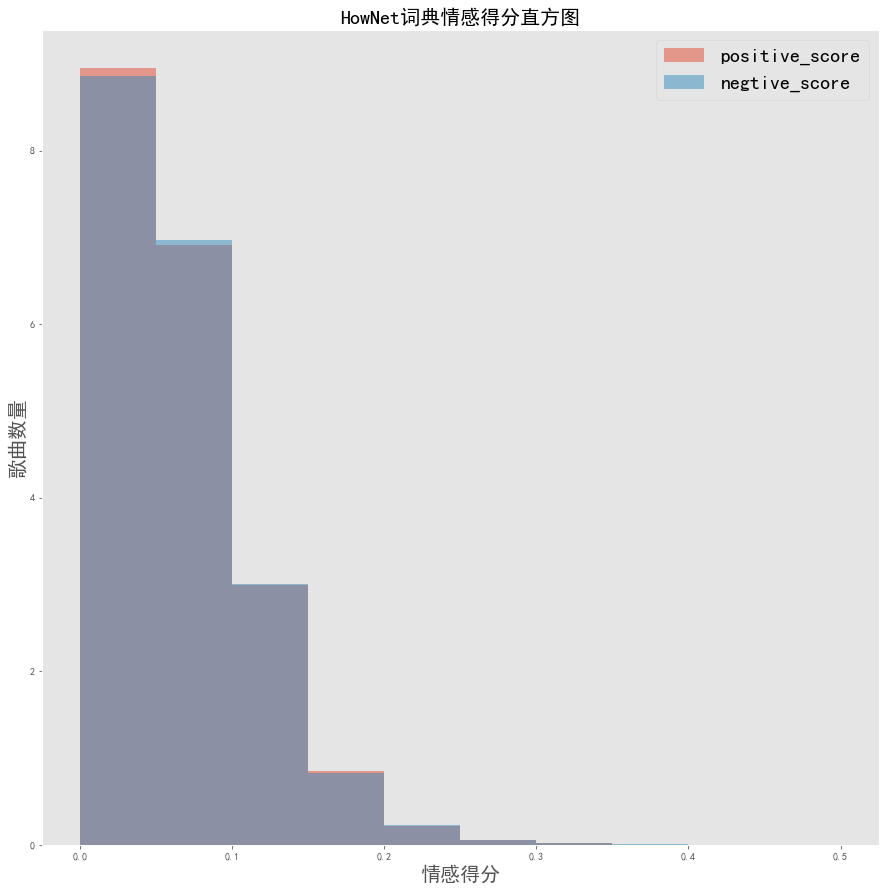

In [307]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab

dat_score = pd.DataFrame(
    np.array([three_scores_of_hownet.str[0].apply(float),
              three_scores_of_hownet.str[1].apply(float)]).reshape(len(three_scores_of_hownet),2),
    columns = ['positive_score','negtive_score']
)

# 生成随机数
d1 = np.random.randn(5000)
d2 = np.random.randn(4000)
fig, ax = plt.subplots(figsize=(15,15))

dens_p, bins, temp  = plt.hist(dat_score['positive_score'].values,bins=10,range = (0,0.5), label = 'positive_score', alpha=0.5,density = True)
dens_n, bins,temp = plt.hist(dat_score['negtive_score'].values, bins=10,range = (0,0.5), label = 'negtive_score', alpha=0.5 ,density = True)

# plt.plot(bins[:100],dens_p, color='red', label='positive_density', linewidth=0.8)
# plt.plot(bins[:100],dens_n, color='blue', label='positive_density', linewidth=0.8)

plt.grid(alpha=0.3)

plt.title('HowNet词典情感得分直方图',fontsize = 20)
plt.xlabel('情感得分',fontsize = 20)
plt.ylabel('歌曲数量',fontsize = 20)
# 显示图例
plt.legend(fontsize = 20)
plt.show()

In [362]:
## 效果并不理想的情感分类
## 现有词库可能并不能满足需求
## 于是想试试别的方式
## 这个在上面运行过了
# se_tokenized_corpus_temp = pd.Series(tokenized_corpus_temp)
# se_tokenized_corpus_temp[se_tokenized_corpus_temp.str[1] == '华晨宇'].str[2]

In [363]:
# 基于词典的情感分类数据

aa = pd.DataFrame(np.array([
    se_tokenized_corpus_temp.str[0],se_tokenized_corpus_temp.str[1],three_scores_of_hownet.apply(score_judge)
]).reshape(3,len(se_tokenized_corpus_temp)).T,
                 columns = ['name','singer','emotion'])
aa.head()

,name,singer,emotion
0,《Young and dream》原创吉他弹唱demo,郑冰冰,positive
1,风雨里 demo,郑冰冰,positive
2,吉他弹唱demo 别让我在你背后哭 升D调,郑冰冰,negtive
3,静夜思2018,郑冰冰,positive
4,弹唱demo 海子《面朝大海春暖花开》,郑冰冰,positive


In [367]:
aa.value_counts(subset = ['emotion'])

emotion 
positive    60413
negtive     30044
mid         11740
dtype: int64

In [366]:
aa.value_counts(subset = ['singer','emotion'])

singer  emotion 
郑冰冰     positive    1081
阿佳      positive     423
邓丽君     positive     403
郑冰冰     negtive      382
刘德华     positive     369
                    ... 
梦然陈瑞    positive       1
梦蓓蕾     mid            1
        positive       1
梦雪      positive       1
龟仙人     positive       1
Length: 8221, dtype: int64

In [400]:
def singer_emotion(name):
    """计算歌手分类"""
    dat_temp = aa[['name','emotion']][aa['singer']==name].groupby('emotion').count()
    if 'positive' in dat_temp.index:
        pos = dat_temp.loc['positive'].values[0]
    else:
        pos = 0
    if 'negtive' in dat_temp.index:
        neg = dat_temp.loc['negtive'].values[0]
    else:
        neg = 0    
    
    if (pos==neg):
        return 'mid'
    elif (pos>neg):
        return 'positive'
    else:
        return 'negtive'

singer_emotion_type = pd.Series(list(set(aa['singer']))).apply(singer_emotion)
singer_emotion_type

0       positive
1       positive
2       positive
3            mid
4       positive
          ...   
4014    positive
4015    positive
4016    positive
4017    positive
4018    positive
Length: 4019, dtype: object

In [407]:
singer_emotion_df = pd.DataFrame([pd.Series(list(set(aa['singer']))),singer_emotion_type],index = ['singer','emotion']).T
singer_emotion_df.to_excel('singer_type.xlsx')
singer_emotion_df

,singer,emotion
0,四郎贡布,positive
1,冰冰超人,positive
2,张贝贝,positive
3,邱佩淇,mid
4,桃十五,positive
...,...,...
4014,精彩词轩,positive
4015,冬飞,positive
4016,谢采妘,positive
4017,阿桑,positive


In [419]:
singer_emotion_df[singer_emotion_df['singer'].isin([
    '凤凰传奇','刀郎','迪克牛仔','崔健','周杰伦','华晨宇','周深','薛之谦','豆腐P','朴树','许巍'
])]

,singer,emotion
418,许巍,positive
466,豆腐P,negtive
475,周深,negtive
727,崔健,positive
1142,刀郎,positive
1643,朴树,negtive
2662,迪克牛仔,negtive
3347,薛之谦,positive
3380,周杰伦,positive
3541,华晨宇,negtive


In [424]:
aa[aa['singer'].isin([
    '凤凰传奇','刀郎','迪克牛仔','崔健','周杰伦','华晨宇','周深','薛之谦','豆腐P','朴树','许巍'
])].value_counts(subset = ['singer','emotion'])

singer  emotion 
周杰伦     positive    93
刀郎      positive    66
许巍      positive    60
周杰伦     negtive     46
迪克牛仔    negtive     45
        positive    39
薛之谦     positive    39
崔健      positive    36
薛之谦     negtive     25
周深      negtive     23
华晨宇     negtive     21
朴树      negtive     20
许巍      negtive     19
周深      positive    17
华晨宇     positive    15
朴树      positive    14
崔健      negtive     13
        mid         11
薛之谦     mid         10
周杰伦     mid          9
刀郎      negtive      9
朴树      mid          7
刀郎      mid          7
许巍      mid          7
迪克牛仔    mid          5
华晨宇     mid          3
周深      mid          1
豆腐P     negtive      1
凤凰传奇    positive     1
dtype: int64

In [445]:
kk = df[df['name'].isin([
    '水手','老鼠爱大米','我很丑，可是我很温柔','下山','大鱼','星星点灯','那些花儿','我和我的祖国','我的滑板鞋'
])]['lyric'].apply(song_test)
df22 = df[df['name'].isin([
    '水手','老鼠爱大米','我很丑，可是我很温柔','下山','大鱼','星星点灯','那些花儿','我和我的祖国','我的滑板鞋'
])]
df22['score'] = kk

df22.reset_index(inplace = True,drop = True)
df22

<ipython-input-445-e7f23d042e1f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df22['score'] = kk


,name,singer,lyric,score
0,老鼠爱大米,卓依婷,"[我听见你的声音, 有种特别的感觉, 让我不断想, 不敢再忘记你, 我记得有一个人, 永远留...","(0.35185185185185186, 0.0, 0.6481481481481481)"
1,那些花儿,童丽,"[那些花儿, , 那片笑声让我想起, 我的那些花儿, 在我生命每一个角落, 静静为我开着, ...","(0.0, 0.0, 1.0)"
2,我和我的祖国,刘紫玲,"[我和我的祖国, , 一刻也不能分割, , 无论我走到哪里, , 都流出一首赞歌, , 我歌...","(0.03333333333333333, 0.03333333333333333, 0.9..."
3,星星点灯,赵鹏,"[抬头的一片天是男儿的一片天, 曾经在满天的星光下做梦的少年, 不知道天多高不知道海多远, ...","(0.21212121212121213, 0.21212121212121213, 0.5..."
4,我很丑，可是我很温柔,赵传,"[每一个晚上, 在梦的旷野, 我是骄傲的巨人, 每一个早晨, 在浴室的镜子前, 却发现自己活...","(0.13793103448275862, 0.1724137931034483, 0.68..."
5,那些花儿,成方圆,"[那片笑声让我想起我的那些花儿, 在我生命每个角落静静为我开着, 我曾以为我会永远守在她身旁...","(0.0, 0.0, 1.0)"
6,那些花儿,范玮琪,"[那片笑声让我想起我的那些花儿, 在我生命每个角落静静为我开着, 我曾以为我会永远守在他身旁...","(0.0, 0.0, 1.0)"
7,那些花儿,米线,"[那片笑声让我想起我的那些花儿, 在我生命每个角落静静为我开着, 我曾以为我会永远守在他身旁...","(0.0, 0.0, 1.0)"
8,我和我的祖国,韩红,"[我和我的祖国 一刻也不能分割, 无论我走到哪里 都留下一首赞歌, 我歌唱每一座高山 我歌唱...","(0.0, 0.0, 1.0)"
9,星星点灯,郑智化,"[抬头的一片天 是男儿的一片天, 曾经在满天的星光下做梦的少年, 不知道天多高 不知道海多远...","(0.19444444444444445, 0.19444444444444445, 0.6..."


In [447]:
df22.loc[23]['score']

(0.0, 0.125, 0.875)

In [62]:
song_test(cut2)

(0.2786885245901639, 0.06557377049180328, 0.6557377049180327)

## 主题模型-情感词典

### NMF模型

In [448]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation


In [449]:
# 首先是TFIDF
datasample = [' '.join(i) for i in tokenized_corpus] # 全部词组成的词表
len(datasample)

102197

In [450]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=15) # df表示包含词项t的条目总数
tfidf = tfidf_vectorizer.fit_transform(datasample)
feature_names = tfidf_vectorizer.get_feature_names()
len(feature_names)

31101

In [451]:
def print_top_words(model, feature_names, n_top_words=20):
    """显示前n_top_words个关键词"""
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [453]:
n_components = 100
n_top_words = 20

nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=9999, alpha=.1,
          l1_ratio=.5)

time0 = time()
W = nmf.fit_transform(tfidf)
temp = nmf.fit(tfidf)
H = temp.components_


feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(temp, feature_names, n_top_words) # 显示特征

print('NMF用时：%0.3fs.'%(time()- time0))

Topic #0: 没有 或许 其实 假装 选择 不懂 习惯 害怕 变得 已经 觉得 发现 至少 剩下 只能 决定 感情 我没有 放弃 舍不得
Topic #1: 夕阳 大地 美丽 芬芳 绽放 远方 花香 天边 盛开 呼唤 流淌 月光 时光 飞扬 化作 阳光 晚霞 点点 心上 清风
Topic #2: 没有 你们 准备 不用 每天 有点 非常 觉得 生活 音乐 很多 无聊 特别 现在 不要 喜欢 保持 一下 他们说 讨厌
Topic #3: 副歌 主歌 郑冰冰 作曲 无情 作词 过渡 如今 演唱 编曲 结尾 痴心 恨你 已成 痴情 间奏 相思 红尘 梦醒 今生
Topic #4: 其实 开心 得到 无谓 恋爱 不要 几多 没法 人人 完全 不必 吸引 不可 清楚 仍然 天生 做到 天天 明白 愉快
Topic #5: 没法 心中 仍然 当天 不可 几多 我心 始终 痴心 热爱 可否 从前 爱意 这刻 愿你 一生 空虚 此刻 期望 温馨
Topic #6: 为你 爱你 永远 陪你 你就是 你是我的 我愿意 爱上你 没有 因为你 是你 一辈子 陪着你 幸福 唯一 爱着你 我的心 愿意 和你 为了你
Topic #7: 不要 美丽 风儿 花儿 人儿 在那 心上人 太阳 你呀 没有 你可知道 千万 心儿 快快 来到 鸟儿 鲜花 衣裳 你为什么 天上
Topic #8: 忘记 在一起 回忆 甜蜜 距离 呼吸 爱你 勇气 秘密 过去 放弃 美丽 心底 分离 永远 我和你 空气 心里 珍惜 相遇
Topic #9: 啦啦啦啦 啦啦 啦啦啦 啊啊啊 哗啦啦 左手 右手 拉拉 笑笑 时时 啤酒 哈哈哈 哎呦 我的宝贝 宝宝 绒花 呀呀呀 嘟嘟嘟 青蛙 天天
Topic #10: 等待 未来 明白 存在 期待 回来 离开 无奈 伤害 悲哀 精彩 徘徊 安排 依赖 感慨 起来 意外 重来 不在 你的爱
Topic #11: 爱情 幸福 美丽 永远 没有 你和我 不要 快乐 甜蜜 让爱 真心 真爱 永恒 浪漫 短暂 两个人 灿烂 属于 爱在 真情
Topic #12: 心肝 偏偏 心内 感情 真情 无情 痴情 明知 亲像 了解 心爱的 已经 知影 这款 悲哀 不知 不通 真心 爱你 爱情
Topic #13: 寂寞 永远 承诺 难过 沉默 快乐 执着 折磨 温柔 错过 冷漠 失落 爱过 解

### LDA模型

In [454]:
import codecs
from datetime import datetime
from gensim import corpora, models
import math


def lda_train(num_topics, datafolder, middatafolder, token_all, dictionary_path=None, corpus_path=None, iterations=5000, passes=1, workers=3):       
    """
    
    
    corpus: corpus里面的存储格式（0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), 
            例如（9，2）这个元素代表第二篇文档中id为9的单词“silver”出现了2次。
    
    """
    
    time1 = datetime.now()
    num_docs = len(token_all)
    doclist = token_all

    if dictionary_path:
        dictionary = corpora.Dictionary.load(dictionary_path) # 加载字典
    else:            
        #构建词汇统计向量并保存
        dictionary = corpora.Dictionary(doclist)
        dictionary.save(middatafolder + 'dictionary.dictionary')
    if corpus_path:
        corpus = corpora.MmCorpus(corpus_path) # 加载corpus
    else:
        corpus = [dictionary.doc2bow(doc) for doc in doclist]
        corpora.MmCorpus.serialize(middatafolder + 'corpus.mm', corpus) # 保存corpus
    tfidf = models.TfidfModel(corpus)
    corpusTfidf = tfidf[corpus]
    time2 = datetime.now()
#     lda_multi = models.ldamulticore.LdaMulticore(corpus=corpusTfidf, id2word=dictionary, num_topics=num_topics, \
#         iterations=iterations, workers=workers, batch=True, passes=passes) # 开始训练
    lda_multi = models.LdaModel(corpus = corpus, id2word = dictionary, random_state = 1,num_topics = num_topics)
    lda_multi.print_topics(num_topics, 30) # 输出主题词矩阵
    print ('lda training time cost is : %s, all time cost is : %s '%(datetime.now()-time2, datetime.now()-time1))
    #模型的保存/ 加载
    lda_multi.save(middatafolder + 'lda_tfidf_%s_%s.model'%(num_topics, iterations)) # 保存模型
    # lda = models.ldamodel.LdaModel.load('zhwiki_lda.model') # 加载模型
    
    # save the doc-topic-id
    topic_id_file = codecs.open(middatafolder + str(num_topics) + '_topic.json', 'w', 'utf-8')
#     for i in range(len(corpusTfidf)):
#         topic_id = lda_multi[corpusTfidf[i]][0][0] # 取概率最大的主题作为文本所属主题
#         topic_id_file.write(str(topic_id)+ ' ')
    for i in range(len(corpusTfidf)):
        try:
            topic_id = lda_best[corpusTfidf[i]][0][0] # 取概率最大的主题作为文本所属主题
            topic_id_file.write(str(topic_id)+ ' ')
    #         print(i)
        except:
            topic_id_file.write(str(-1)+ ' ')
            
    topic_id_file.close()

In [455]:
# 训练
## 训练的时候要改一下代码

datafolder = 'E:/jupyterdir/jupyter_dir/非结构化/期末/ChineseLyrics-master/lda/'
middatafolder = 'E:/jupyterdir/jupyter_dir/非结构化/期末/ChineseLyrics-master/lda/'
dictionary_path = middatafolder + 'dictionary.dictionary'
corpus_path = middatafolder + 'corpus.mm'
# ldamodel_path = middatafolder + 'lda.model'
# 5~200

# lda_train(5,datafolder,middatafolder,tokenized_corpus)
lda_train(100,datafolder,middatafolder,tokenized_corpus,dictionary_path,corpus_path)

# topics = range(6,201)
# for i in topics:
#     print('第',i,'主题数模型训练')
#     lda_train(i,datafolder,middatafolder,tokenized_corpus,dictionary_path,corpus_path)

lda training time cost is : 0:05:06.819208, all time cost is : 0:05:14.024892 


In [94]:
# from gensim import corpora, models
 

# def ldamodel(num_topics):
#     """lda的模型函数
#     传入了训练好的tokenized_corpus
#     """
 
#     dictionary = corpora.Dictionary(tokenized_corpus)
#     corpus = [dictionary.doc2bow(text) for text in
#               tokenized_corpus]  # corpus里面的存储格式（0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)
    
#     # 例如（9，2）这个元素代表第二篇文档中id为9的单词“silver”出现了2次。 
    
# #     corpora.MmCorpus.serialize('corpus.mm', corpus) # 存语料
#     lda = models.LdaModel(corpus=corpus, id2word=dictionary, random_state=1,
#                           num_topics=num_topics)  # random_state 等价于随机种子的random.seed()，使每次产生的主题一致
 
#     topic_list = lda.print_topics(num_topics, 30)
#     print("主题的单词分布为：\n")
#     for topic in topic_list:
#         print(topic)
#     return lda,dictionary,topic_list


In [60]:
import math
def perplexity(ldamodel, testset, dictionary, size_dictionary, num_topics):
    """计算评价指标：困惑度
    
    Parameters
    ----------
    ldamodel: 之前gensim设置好的lda模型
    testset: 
    dictionary:
    size_dictionary:
    num_topics: 主题数
    """
    
    print ('the info of this ldamodel: \n')
    print ('num of testset: %s; size_dictionary: %s; num of topics: %s'%(len(testset), size_dictionary, num_topics))
    prep = 0.0
    prob_doc_sum = 0.0
    topic_word_list = [] # store the probablity of topic-word:[(u'business', 0.010020942661849608),(u'family', 0.0088027946271537413)...]
    for topic_id in range(num_topics):
        topic_word = ldamodel.show_topic(topic_id, size_dictionary)
        dic = {}
        for word, probability in topic_word:
            dic[word] = probability
        topic_word_list.append(dic)
    doc_topics_ist = [] #store the doc-topic tuples:[(0, 0.0006211180124223594),(1, 0.0006211180124223594),...]
    for doc in testset:
        doc_topics_ist.append(ldamodel.get_document_topics(doc, minimum_probability=0))
    testset_word_num = 0
    for i in range(len(testset)):
        prob_doc = 0.0 # the probablity of the doc
        doc = dict(testset[i])
        # print(doc)
        doc_word_num = 0 # the num of words in the doc
        for word_id, num in doc.items():
            prob_word = 0.0 # the probablity of the word 
            doc_word_num += num
            word = dictionary[word_id]
            for topic_id in range(num_topics):
                # cal p(w) : p(w) = sumz(p(z)*p(w|z))
                prob_topic = doc_topics_ist[i][topic_id][1]
                prob_topic_word = topic_word_list[topic_id][word]
                prob_word += prob_topic*prob_topic_word
            prob_doc += math.log(prob_word) # p(d) = sum(log(p(w)))
        prob_doc_sum += prob_doc
        testset_word_num += doc_word_num
    prep = math.exp(-prob_doc_sum/testset_word_num) # perplexity = exp(-sum(p(d)/sum(Nd))
    print ("the perplexity of this ldamodel is : %s"%prep)
    return prep


In [61]:

middatafolder = 'E:/jupyterdir/jupyter_dir/非结构化/期末/ChineseLyrics-master/lda/'
dictionary_path = middatafolder + 'dictionary.dictionary'
corpus_path = middatafolder + 'corpus.mm'

# LDA主题模型的评价指标是困惑度，困惑度越小，模型越好。
topics = range(5,201)
perplexity_list = []

corpus = corpora.MmCorpus(corpus_path)
    
for num_topics in topics:
    ldamodel_path = middatafolder + 'lda_tfidf_'+str(num_topics)+'_5000.model'
    dictionary = corpora.Dictionary.load(dictionary_path)
    # 载入多个模型
    lda_multi = models.ldamodel.LdaModel.load(ldamodel_path)
    testset = []
    # 分训练集
    for i in range(int(corpus.num_docs/300)):
        testset.append(corpus[i*300])
    prep = perplexity(lda_multi, testset, dictionary, len(dictionary.keys()), num_topics)
    perplexity_list.append(prep)

the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 5
the perplexity of this ldamodel is : 171.20128826327414
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 6
the perplexity of this ldamodel is : 171.86051274922687
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 7
the perplexity of this ldamodel is : 173.67601221710564
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 8
the perplexity of this ldamodel is : 175.86265831033194
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 9
the perplexity of this ldamodel is : 181.0495337226621
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 10
the perplexity of this ldamodel is : 190.11640679517208
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 11
the perplexity of t

the perplexity of this ldamodel is : 191.5283858690283
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 61
the perplexity of this ldamodel is : 191.14888024297218
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 62
the perplexity of this ldamodel is : 191.60342964794984
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 63
the perplexity of this ldamodel is : 189.86370799097332
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 64
the perplexity of this ldamodel is : 189.73299906993898
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 65
the perplexity of this ldamodel is : 189.70341009103907
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 66
the perplexity of this ldamodel is : 189.34234386859356
the info of this ldamodel: 

num of testset: 340; s

the perplexity of this ldamodel is : 168.34924787307872
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 116
the perplexity of this ldamodel is : 167.85591445489956
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 117
the perplexity of this ldamodel is : 167.40021720327874
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 118
the perplexity of this ldamodel is : 166.34493547278998
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 119
the perplexity of this ldamodel is : 165.97709433090384
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 120
the perplexity of this ldamodel is : 166.0118474573809
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 121
the perplexity of this ldamodel is : 165.01369958745303
the info of this ldamodel: 

num of testset: 

the perplexity of this ldamodel is : 148.4728543004912
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 171
the perplexity of this ldamodel is : 148.3625396616381
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 172
the perplexity of this ldamodel is : 148.3328570520474
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 173
the perplexity of this ldamodel is : 147.7139407442672
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 174
the perplexity of this ldamodel is : 147.50996603802105
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 175
the perplexity of this ldamodel is : 147.6472623579086
the info of this ldamodel: 

num of testset: 340; size_dictionary: 283361; num of topics: 176
the perplexity of this ldamodel is : 146.39715500334708
the info of this ldamodel: 

num of testset: 340;

KeyboardInterrupt: 

想法：

根据lda的结果进行主题分类，将主题词记录下来，构建每首歌的主题数量的0-1变量

对同一分类的歌词进行新分词

分词以后形成新的意象词典

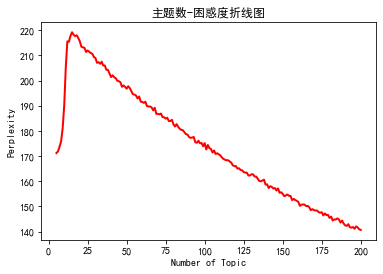

In [26]:
def graph_draw(topic,perplexity):             #做主题数与困惑度的折线图
    x=topic
    y=perplexity
    plt.plot(x,y,color="red",linewidth=2)
    plt.xlabel("主题数")
    plt.ylabel("困惑度")
    plt.title("主题数-困惑度折线图")
    plt.show()
    
graph_draw(topics,perplexity_list)

In [63]:
# 困惑度表明，8个主题以下或者100主题以上效果最好
num_topics = 8
ldamodel_path = 'E:/jupyterdir/jupyter_dir/非结构化/期末/ChineseLyrics-master/lda/lda_tfidf_'+str(num_topics)+'_5000.model'
lda_best = models.ldamodel.LdaModel.load(ldamodel_path)

topic_list = lda_best.print_topics(num_topics,30)
print("主题的单词分布为：\n")
for topic in topic_list:
    
    print(topic[1].split('"')[1::2])

主题的单词分布为：

['你', '一生', '中', '共', '与你', '愿', '似', '未', '难', '便', '心中', '唔', '心', '一世', '笑', '世间', '里', '我心', '时', '为你', '知', '令', '几多', '你我', '不可', '恨', '永', '日', '见', '我愿']
['天地', '英雄', '中', '你', '岁月', '轮回', '千年', '一场', '南无', '中国', '梦', '里', '生死', '青春', '天下', '梭哈', '听', '红尘', '只为', '燃烧', '天涯', '佛', '空白', '热血', '一身', '时代', '江湖', '战场', '你是', '传说']
['你', '会', '没有', '爱', '想', '没', '我的', '一个', '时间', '太', '说', '现在', '世界', '不会', '里', '做', '太多', '快乐', '生活', '需要', '未来', '感觉', '幸福', '更', '一起', '也许', '最后', '不想', '其实', '已经']
['月', '人间', '相思', '甲', ' ', '诃', '合', '花', '兮', '天涯', '不知', '红尘', '女', '酒', '欲', '唎', '相逢', '一曲', '江湖', '桃花', '唱', '少年', '红颜', '悠悠', '茫茫', '落', '花开', '叹', '梦', '阮']
['你', '美', '噢', '追', '滋味', '飞', '醉', '心碎', '伤悲', '一杯', '无所谓', '泪', '妳', '流泪', '玫瑰', '相随', '吹', '体会', '回', '憔悴', '安慰', '完美', '爱', '忘不了', '沉醉', '著', '一回', '疲惫', '枯萎', '陪']
['你', '里', '我的', '中', '美丽', '梦', '思念', '天空', '永远', '阳光', '时光', '回忆', '温暖', '梦想', '地方', '一个', '生命', '带', '希望', '世界', '唱', '幸福', '岁月', '心中', '远方', '

上面是主题模型的结果，共分为八个主题。根据语义可以总结为

相见苦不得，英雄撒热血，假想的生活，红尘复古风，疲惫与憔悴，温暖小幸福，家庭与生活，

分类效果很差，主题模糊，且最终结果绝大部分都被分进了第一类中

In [85]:
# 记录每篇文档的分类

num_topics = 8
ldamodel_path = 'E:/jupyterdir/jupyter_dir/非结构化/期末/ChineseLyrics-master/lda/lda_tfidf_'+str(num_topics)+'_5000.model'
lda_best = models.ldamodel.LdaModel.load(ldamodel_path)
topic_id_file = codecs.open(middatafolder + '8_topic.json', 'w', 'utf-8')
corpus = corpora.MmCorpus(corpus_path) 
tfidf = models.TfidfModel(corpus)
corpusTfidf = tfidf[corpus]
for i in range(len(corpusTfidf)):
    try:
        topic_id = lda_best[corpusTfidf[i]][0][0] # 取概率最大的主题作为文本所属主题
        topic_id_file.write(str(topic_id)+ ' ')
#         print(i)
    except:
        topic_id_file.write(str(-1)+ ' ')
        
topic_id_file.close()

### 100分类LDA模型

最后用的模型

In [10]:
middatafolder = 'E:/jupyterdir/jupyter_dir/非结构化/期末/ChineseLyrics-master/lda/'
dictionary_path = middatafolder + 'dictionary.dictionary'
corpus_path = middatafolder + 'corpus.mm'

In [456]:
# 再看看100主题的关键词

## 全100分类！
num_topics = 100
ldamodel_path = 'E:/jupyterdir/jupyter_dir/非结构化/期末/ChineseLyrics-master/lda/lda_tfidf_'+str(num_topics)+'_5000.model'
lda_best = models.ldamodel.LdaModel.load(ldamodel_path)

topic_list = lda_best.print_topics(num_topics,50)
print("100主题的单词分布为：\n")
for topic in topic_list:
    
    print(topic[1].split('"')[1::2])

100主题的单词分布为：

['分享', '忘', '过后', '走吧', '舞', '恋', '许', '美的', '高山', '忘却', '世事', '烧', '不离不弃', '誰', '在你身旁', '南方', '何人', '淡淡的', '上有', '血液', '赐', '冬季', '片刻', '迷雾', '赐予', '新娘', '陪伴我', '心房', '人世', '夏季', '去远方', '点燃', '三生', '眉眼', '晴朗', '冬', '回响', '愛', '泣', '碗', '已久', '枕', '阴阳', '胸', '迎', '不要害怕', '飘摇', '长相', '逢', '日']
['一条', '吉他', '古老', '圆', '黎明', '追寻', '乌云', '守护', '清澈', '飘零', '烽火', '皆', '掩埋', '江', '携手', '客', '划破', '终将', '流淌', '聚', '苍穹', '几许', '西风', '长剑', '安康', '铺满', '依依', '别后', '中华', '轨迹', '漂浮', '印记', '山谷', '来来', '拼搏', '尘土', '爹爹', '一轮', '黄河', '染红', '绚丽', '传说', '背上', '承载', '跳起', '婆娑', '长空', '犹如', '燃尽', '哗啦啦']
['牵挂', '天涯', '断', '忽然', '莫', '飞过', '城', '埋', '星辰', '变化', '繁华', '无常', '惆怅', '变了', '散落', '期望', '喧闹', '世俗', '泪光', '温暖我', '伴', '雨伞', '娃娃', '可怕', '伞', '沧桑', '苹果', '眼看', '滴滴', '中央', '长安', '荆棘', '踏过', '无限', '岁月', '尊严', '翔', '回眸', '修行', '风霜', '里', '脸庞', '去飞', '年少轻狂', '望穿', '相知', '开满', '等你来', '别了', '迷茫']
['一只', '剑', '几多', '灯', '爱着你', '遥远的', '天际', '空虚', '遥望', '乱世', '唯', '银河', '当年', '走出', '随风飘', '烂', '最

In [457]:
## 存取每篇文档的分类

num_topics = 100
ldamodel_path = 'E:/jupyterdir/jupyter_dir/非结构化/期末/ChineseLyrics-master/lda/lda_tfidf_'+str(num_topics)+'_5000.model'
lda_best = models.ldamodel.LdaModel.load(ldamodel_path)

topic_id_file = codecs.open(middatafolder + '100_topic.json', 'w', 'utf-8')
corpus = corpora.MmCorpus(corpus_path) 
tfidf = models.TfidfModel(corpus)
corpusTfidf = tfidf[corpus]
for i in range(len(corpusTfidf)):
    try:
        topic_id = lda_best[corpusTfidf[i]][0][0] # 取概率最大的主题作为文本所属主题
        topic_id_file.write(str(topic_id)+ ' ')
#         print(i)
    except:
        topic_id_file.write(str(-1)+ ' ')
#         print(i)
topic_id_file.close()

In [458]:
# 读取主题看看
filename = middatafolder + '100_topic.json'
with open(filename,'r') as fjson:
    dat = fjson.readline()
    
cluster_1 = dat.split(' ')
print('歌曲总数：',len(cluster_1))

# 取top10【最关心的】
rank = pd.Series(cluster_1).value_counts()[:10]
print('top10主题的歌词总数：',rank.sum())
print('100分类出现最多的top10主题:\n',rank,'\n')
idx = list(map(int,rank.index))
for index in idx:
    
    print('主题',index)
    print(topic_list[index][1].split('"')[1::2])

歌曲总数： 102198
top10主题的歌词总数： 56731
100分类出现最多的top10主题:
 14    10215
2      6767
0      6753
10     6120
1      6117
5      4780
3      4521
4      4457
7      3515
9      3486
dtype: int64 

主题 14
['你', '会', '没有', '爱', '我的', '时间', '不会', '说', '也许', '一直', '想', '回忆', '真的', '现在', '不能', '最后', '已经', '没', '爱情', '太多', '总是', '我会', '是我', '变成', '无法', '只能', '一点', '就这样', '选择', '太', '永远', '曾经', '我知道', '忘记', '放弃', '感觉', '能够', '需要', '发现', '难过', '习惯', '幸福', '知道', '变得', '不想', '心', '爱你', '想要', '你说', '是你']
主题 2
['牵挂', '天涯', '断', '忽然', '莫', '飞过', '城', '埋', '星辰', '变化', '繁华', '无常', '惆怅', '变了', '散落', '期望', '喧闹', '世俗', '泪光', '温暖我', '伴', '雨伞', '娃娃', '可怕', '伞', '沧桑', '苹果', '眼看', '滴滴', '中央', '长安', '荆棘', '踏过', '无限', '岁月', '尊严', '翔', '回眸', '修行', '风霜', '里', '脸庞', '去飞', '年少轻狂', '望穿', '相知', '开满', '等你来', '别了', '迷茫']
主题 0
['分享', '忘', '过后', '走吧', '舞', '恋', '许', '美的', '高山', '忘却', '世事', '烧', '不离不弃', '誰', '在你身旁', '南方', '何人', '淡淡的', '上有', '血液', '赐', '冬季', '片刻', '迷雾', '赐予', '新娘', '陪伴我', '心房', '人世', '夏季', '去远方', '点燃', '三生', '眉眼',

100分类中，排名前十的主题可以归纳为：

1.幸福回忆，2.温暖陪伴，3.本真热爱，4.清纯之恋，5.家国社会，6.梦幻灿烂，7.遥望虚无，8.江湖纷繁，9.知音难觅，10.冲破黑暗

主题效果还是一般，但已经初见成效

可能是数据的问题，200类也试了，效果其实已经差不多了

In [93]:
## 200分类！
num_topics = 200
ldamodel_path = 'E:/jupyterdir/jupyter_dir/非结构化/期末/ChineseLyrics-master/lda/lda_tfidf_'+str(num_topics)+'_5000.model'
lda_best = models.ldamodel.LdaModel.load(ldamodel_path)

topic_id_file = codecs.open(middatafolder + '200_topic.json', 'w', 'utf-8')
corpus = corpora.MmCorpus(corpus_path) 
tfidf = models.TfidfModel(corpus)
corpusTfidf = tfidf[corpus]
for i in range(len(corpusTfidf)-1):
    try:
        topic_id = lda_best[corpusTfidf[i]][0][0] # 取概率最大的主题作为文本所属主题
        topic_id_file.write(str(topic_id)+ ' ')
    except:
        topic_id_file.write(str(-1)+ ' ')

topic_id_file.close()



In [126]:
# 读取主题看看
filename = middatafolder + '200_topic.json'
with open(filename,'r') as fjson:
    dat = fjson.readline()
    
cluster_1 = dat.split(' ')
len(dat)

rank = pd.Series(cluster_1).value_counts()[:10]
print('top10主题的歌词总数：',rank.sum())
print('200分类出现最多的top10主题:\n',rank,'\n')
idx = list(map(int,rank.index))
for index in idx:
    if index == -1:
        print('主题',index)
        print('关键词为空')
    else:
        print('主题',index)
        print(topic_list[index][1].split('"')[1::2])

top10主题的歌词总数： 41284
200分类出现最多的top10主题:
 3     5374
0     5157
5     5031
2     4690
4     4174
1     4020
14    3538
-1    3379
8     2990
6     2931
dtype: int64 

主题 3
['一只', '剑', '几多', '灯', '爱着你', '遥远的', '天际', '空虚', '遥望', '乱世', '唯', '银河', '当年', '走出', '随风飘', '烂', '最大', '浮云', '朦胧', '凄凉', '一滴', '里', '星空', '高歌', '争取', '听不到', '马蹄', '取', '青蛙', '征战', '只有一个你', '水流', '叹', '叶落', '狂奔', '刀剑', '一战', '咏', '放声', '雨落', '弯弯的', '让你走', '一封', '到头来', '电', '扣', '笼罩', '扇', '一片片', '万事']
主题 0
['分享', '忘', '过后', '走吧', '舞', '恋', '许', '美的', '高山', '忘却', '世事', '烧', '不离不弃', '誰', '在你身旁', '南方', '何人', '淡淡的', '上有', '血液', '赐', '冬季', '片刻', '迷雾', '赐予', '新娘', '陪伴我', '心房', '人世', '夏季', '去远方', '点燃', '三生', '眉眼', '晴朗', '冬', '回响', '愛', '泣', '碗', '已久', '枕', '阴阳', '胸', '迎', '不要害怕', '飘摇', '长相', '逢', '日']
主题 5
['变', '改变', '仍然', '正', '玫瑰', '灰', '里', '雨季', '所爱', '理会', '火焰', '轻轻地', '繁星', '荣耀', '辗转', '唱到', '抽', '阳光下', '朝夕', '秋千', '淡', '女儿', '那条', '信心', '深深地', '前', '中', '纷扰', '从前', '没变', '雨点', '春去', '不须', '剪', '天', '未', '犹', '夜风', '笑脸',

## 构建新词表

根据lda的分类，进行关键词意象抽取，重新构建词典

In [459]:
# 读取主题看看
filename = middatafolder + '100_topic.json'
with open(filename,'r') as fjson:
    dat = fjson.readline()
cluster_1 = dat.split(' ')
print('歌曲总数：',len(cluster_1))

歌曲总数： 102198


In [552]:
rank = pd.Series(cluster_1).value_counts()[:10]
idx = list(map(int,rank.index))
print('top10的主题序号为',idx)
theme = ['幸福回忆','温暖陪伴','本真热爱','青春放纵','家国社会','梦幻灿烂','遥望虚无','江湖纷繁','知音难觅','冲破黑暗']
print(theme)
idx_n = list(zip(idx,theme))

top10的主题序号为 [14, 2, 0, 10, 1, 5, 3, 4, 7, 9]
['幸福回忆', '温暖陪伴', '本真热爱', '青春放纵', '家国社会', '梦幻灿烂', '遥望虚无', '江湖纷繁', '知音难觅', '冲破黑暗']


In [461]:
def cut_cluster_ofLDA(dataframe, cluster_num):
    """目标是使用前10的类的歌词，重新分词构建主题词典
    或者不止前10类
    """
    if cluster_num in idx:
        print(idx_n[np.argwhere(np.array(idx)==cluster_num)[0][0]])
    cluster_num = str(cluster_num)
    # 同一类的索引，一行array
    index_clustered = np.argwhere(np.array(cluster_1)==cluster_num).reshape(-1)
#     dataframe.reset_index(inplace = True)
    
    df_new = dataframe.iloc[index_clustered]
    print('该分类的歌曲数量：',len(df_new))
    print(df_new['lyric'].head())
    tokenized_corpus_temp = cut_all_kw(df_new)
#     tokenized_corpus = [lyric[2] for lyric in tokenized_corpus_temp]
    return tokenized_corpus_temp


tokenized_corpus_temp_14 = cut_cluster_ofLDA(df, 14)
tokenized_corpus_temp_2  = cut_cluster_ofLDA(df, 2 )
tokenized_corpus_temp_0  = cut_cluster_ofLDA(df, 0 )
tokenized_corpus_temp_10 = cut_cluster_ofLDA(df, 10)
tokenized_corpus_temp_1  = cut_cluster_ofLDA(df, 1 )
tokenized_corpus_temp_5  = cut_cluster_ofLDA(df, 5 )
tokenized_corpus_temp_3  = cut_cluster_ofLDA(df, 3 )
tokenized_corpus_temp_4  = cut_cluster_ofLDA(df, 4 )
tokenized_corpus_temp_7  = cut_cluster_ofLDA(df, 7 )
tokenized_corpus_temp_9  = cut_cluster_ofLDA(df, 9 )
tokenized_corpus_temp_detail_theme = np.array([
    tokenized_corpus_temp_14 ,
    tokenized_corpus_temp_2  ,
    tokenized_corpus_temp_0  ,
    tokenized_corpus_temp_10 ,
    tokenized_corpus_temp_1  ,
    tokenized_corpus_temp_5  ,
    tokenized_corpus_temp_3  ,
    tokenized_corpus_temp_4  ,
    tokenized_corpus_temp_7  ,
    tokenized_corpus_temp_9  
])

(14, '幸福回忆')
该分类的歌曲数量： 10215
2      [别让我在你背后哭 升D调, , 主歌1, 冷冷地望着眼前这一幕, 无所谓还在不在乎, 你的...
26     [如果我不要结果 降A调, , 主歌1, 如果往事的路, 长过我想你的夜幕, 就让眼前的灯火...
28     [依然痴心绝对 升A调, 作词 海杰, 作曲 郑冰冰, , 主歌1, 记得当初狠心一别, 杳...
56     [《自以为事》, 作词 徐成, 作曲 郑冰冰, 编曲 彭扬, 演唱 络秋, 后期 徐成&郑冰...
102    [倒数, , 主歌1 男, 路灯又灭了一半, 想说的话却说不完, 你背对着我 往天空看, 看...
Name: lyric, dtype: object
(2, '温暖陪伴')
该分类的歌曲数量： 6767
6     [三生三世, 作词 月怀玉, 作曲 郑冰冰, 编曲 QING, 演唱 郑冰冰, 和声 郑冰冰...
7     [《爆裂古风》, , 主歌1, 风穿过客栈 花散落酒坊, 谁在杯中窥探 未解的遗憾, 轻摇手...
33    [苹果树上的外婆 升D调, , 主歌1, 关于童年好多事已不记得, 可这个梦却在心里深刻, ...
35    [遇见快乐 升D调, , 我们很多时候爱寻找星空, 却不曾停下触摸影子的痛, 刻意的把自己打...
52    [《井底之娃》 升D调, 作词 乐音, 作曲 郑冰冰, , 主歌1, 你一定没见过一朵云笑成...
Name: lyric, dtype: object
(0, '本真热爱')
该分类的歌曲数量： 6753
51     [天元之弈星, , 主歌1, 世间的事 如何才能遗忘, 时光荏苒问旧伤, 落一子洁白为何静止...
60     [《中华之龙》升G调, 作词 张然, 作曲 郑冰冰, 吉他弹唱 郑冰冰, , 主歌1, 喜马...
77     [过眼云烟, , 副歌1, 你的视线 你的表演, 你的侧脸 你的热烈, , 主歌1, 也许不...
92     [温暖 7品 G调转A调, , （主歌）1, 我愿变成一双翅膀, 带你飞翔, 一起看这个世界...
100    [I Love You, 作词 郑冰冰, 作曲 郑冰冰, 编曲 彭扬, 演唱 郑冰冰, 后期...
Name: lyric, 

<ipython-input-461-a9ac369e1b8c>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  tokenized_corpus_temp_detail_theme = np.array([


In [30]:
# for item in tokenized_corpus_temp_0:
#     # 看一下都有哪些歌
#     print(item[0])

In [186]:
# import pickle
# 保存一下
# pickle.dump(tokenized_corpus_temp_detail_theme,open('tokenized_corpus_temp_detail_theme.pkl','wb'))

In [299]:
# 另一种构造，取前500词，效果一般，重复词太多
tokenized_corpus_detail_theme_0 = [line[2] for line in tokenized_corpus_temp_detail_theme[0]]
words_freq_0, words_all_0 = words_freq_stat(tokenized_corpus_detail_theme_0)
dict0 = words_freq_0[:500]

tokenized_corpus_detail_theme_1 = [line[2] for line in tokenized_corpus_temp_detail_theme[1]]
words_freq_1, words_all_1 = words_freq_stat(tokenized_corpus_detail_theme_1)
dict1 = words_freq_1[:500]

tokenized_corpus_detail_theme_2 = [line[2] for line in tokenized_corpus_temp_detail_theme[2]]
words_freq_2, words_all_2 = words_freq_stat(tokenized_corpus_detail_theme_2)
dict2 = words_freq_2[:500]

tokenized_corpus_detail_theme_3 = [line[2] for line in tokenized_corpus_temp_detail_theme[3]]
words_freq_3, words_all_3 = words_freq_stat(tokenized_corpus_detail_theme_3)
dict3 = words_freq_3[:500]

tokenized_corpus_detail_theme_4 = [line[2] for line in tokenized_corpus_temp_detail_theme[4]]
words_freq_4, words_all_4 = words_freq_stat(tokenized_corpus_detail_theme_4)
dict4 = words_freq_4[:500]

tokenized_corpus_detail_theme_5 = [line[2] for line in tokenized_corpus_temp_detail_theme[5]]
words_freq_5, words_all_5 = words_freq_stat(tokenized_corpus_detail_theme_5)
dict5 = words_freq_5[:500]

tokenized_corpus_detail_theme_6 = [line[2] for line in tokenized_corpus_temp_detail_theme[6]]
words_freq_6, words_all_6 = words_freq_stat(tokenized_corpus_detail_theme_6)
dict6 = words_freq_6[:500]

tokenized_corpus_detail_theme_7 = [line[2] for line in tokenized_corpus_temp_detail_theme[7]]
words_freq_7, words_all_7 = words_freq_stat(tokenized_corpus_detail_theme_7)
dict7 = words_freq_7[:500]

tokenized_corpus_detail_theme_8 = [line[2] for line in tokenized_corpus_temp_detail_theme[8]]
words_freq_8, words_all_8 = words_freq_stat(tokenized_corpus_detail_theme_8)
dict8 = words_freq_8[:500]

tokenized_corpus_detail_theme_9 = [line[2] for line in tokenized_corpus_temp_detail_theme[9]]
words_freq_9, words_all_9 = words_freq_stat(tokenized_corpus_detail_theme_9)
dict9 = words_freq_9[:500]

In [462]:
tokenized_corpus_detail_theme_0 = [line[2] for line in tokenized_corpus_temp_detail_theme[0]]
words_freq_0, words_all_0 = words_freq_stat(tokenized_corpus_detail_theme_0)
dict0 = words_freq_0#[words_freq_0>1000]

tokenized_corpus_detail_theme_1 = [line[2] for line in tokenized_corpus_temp_detail_theme[1]]
words_freq_1, words_all_1 = words_freq_stat(tokenized_corpus_detail_theme_1)
dict1 = words_freq_1#[words_freq_1>1000]

tokenized_corpus_detail_theme_2 = [line[2] for line in tokenized_corpus_temp_detail_theme[2]]
words_freq_2, words_all_2 = words_freq_stat(tokenized_corpus_detail_theme_2)
dict2 = words_freq_2#[words_freq_2>1000]

tokenized_corpus_detail_theme_3 = [line[2] for line in tokenized_corpus_temp_detail_theme[3]]
words_freq_3, words_all_3 = words_freq_stat(tokenized_corpus_detail_theme_3)
dict3 = words_freq_3#[words_freq_3>1000]

tokenized_corpus_detail_theme_4 = [line[2] for line in tokenized_corpus_temp_detail_theme[4]]
words_freq_4, words_all_4 = words_freq_stat(tokenized_corpus_detail_theme_4)
dict4 = words_freq_4#[words_freq_4>1000]

tokenized_corpus_detail_theme_5 = [line[2] for line in tokenized_corpus_temp_detail_theme[5]]
words_freq_5, words_all_5 = words_freq_stat(tokenized_corpus_detail_theme_5)
dict5 = words_freq_5#[words_freq_5>1000]

tokenized_corpus_detail_theme_6 = [line[2] for line in tokenized_corpus_temp_detail_theme[6]]
words_freq_6, words_all_6 = words_freq_stat(tokenized_corpus_detail_theme_6)
dict6 = words_freq_6#[words_freq_6>1000]

tokenized_corpus_detail_theme_7 = [line[2] for line in tokenized_corpus_temp_detail_theme[7]]
words_freq_7, words_all_7 = words_freq_stat(tokenized_corpus_detail_theme_7)
dict7 = words_freq_7#[words_freq_7>1000]

tokenized_corpus_detail_theme_8 = [line[2] for line in tokenized_corpus_temp_detail_theme[8]]
words_freq_8, words_all_8 = words_freq_stat(tokenized_corpus_detail_theme_8)
dict8 = words_freq_8#[words_freq_8>1000]

tokenized_corpus_detail_theme_9 = [line[2] for line in tokenized_corpus_temp_detail_theme[9]]
words_freq_9, words_all_9 = words_freq_stat(tokenized_corpus_detail_theme_9)
dict9 = words_freq_9#[words_freq_9>1000]

In [463]:
dict0

爱      6906
没有     6455
时间     3292
爱情     3258
心      3089
       ... 
嘥         1
拙         1
沉住气       1
三经        1
武件        1
Length: 59376, dtype: int64

In [481]:
for dictk in [dict0,dict1,dict2,dict3,dict4,dict5,dict6,dict7,dict8,dict9]:
    print(len(dictk))

59376
59827
65584
53963
60002
46566
46480
48877
40932
37732


In [464]:
## 取出每个dict中独特的部分

dictionary_theme = {}
dictlist = [dict0,dict1,dict2,dict3,dict4,dict5,dict6,dict7,dict8,dict9]
for i in range(10):
    dictionary_theme[str(i)] = []
    if i != 0:
        dic_temp = set(dict0.index)
    else:
        dic_temp = set(dict1.index)
    
    for j in range(10):
        if j != i:
            dic_temp = set(dic_temp) | set(dictlist[j].index)
        else:
            pass
        
    dictionary_theme[str(i)].extend(list(set(dictlist[i].index)-dic_temp))
    dictionary_theme[str(i)] = set(dictionary_theme[str(i)])

In [20]:
for i in range(10):
    print(len(set(dictionary_theme[str(i)])))

12757
13712
20281
10801
14855
8623
9055
9897
8094
5700


In [139]:
dictionary_theme['0']

{'事怨',
 '猜不到的结尾',
 '小醉仙',
 '我的内心戏',
 '同飞',
 '魚的',
 '活比',
 '靚女',
 '音乐性',
 '挣多',
 '走过的零星痕迹',
 '歇斯',
 '店名',
 '搁浅的画面',
 '喂喂搵边位',
 '锤出',
 '黑粉',
 '贤请',
 '喝些',
 '热熨不起',
 '降低要求',
 '行找',
 '九百九十八',
 '小天',
 '滚吧带着你那肮脏的身体',
 '我们到底还能相信什么',
 '轻轻的爱',
 '车鸣',
 '你习',
 '什么最流行',
 '被触',
 '当红少爷',
 '相违',
 '新番',
 '空不只',
 '儿童节',
 '背锅',
 '给举',
 '收情',
 '电让',
 '补缺',
 '原来这才是真的你',
 '宠罩',
 '太白金星',
 '暂憩',
 '哪经',
 '呜别',
 '文体',
 '每套',
 '靜夜',
 '鬼才懂你',
 '急便',
 '筷多',
 '却幸',
 '稳得',
 '同洲',
 '七月的一天',
 '包成',
 '哈到',
 '孤单大街',
 '偽钞',
 '尽挂',
 '磨叽',
 '当眼框',
 '受椎心',
 '知彼知己',
 '胡里胡涂',
 '拼颜值',
 '挫愈勇',
 '霍乱',
 '我好像在说谎',
 '括约肌',
 '令人叹服',
 '越藏越',
 '土遁',
 '见儿',
 '选衬',
 '了若指掌',
 '停在你的时间',
 '时阵乎',
 '记得曾遇见你',
 '急进',
 '猫冬',
 '用目',
 '圣堂之门',
 '如果你没有爱上他',
 '你的小说',
 '拆线',
 '流星锤',
 '每股',
 '狂而',
 '桂说',
 '机油',
 '钳制',
 '缩回',
 '爱的野火',
 '最顶',
 '原来我们都是爱着的',
 '无聊派',
 '简简单单受点伤',
 '泪会少',
 '下手太重',
 '临帖',
 '终面',
 '光练',
 '能安',
 '朝思目',
 '雨还是不停地落下',
 '鸡懒',
 '地扣',
 '时灭',
 '查无',
 '我就像个小孩',
 '老多人',
 '左孝虎',
 '伤心俱乐部',
 '想你是一个秘密',
 '跛入',
 '干湿',
 '骑来',
 '我想更爱你',
 '千恩万

In [73]:
# 老词典

df_0 = pd.DataFrame(dict0,columns = ['freq'])
df_0.reset_index(inplace = True)
df_0['cluster'] = '0'
k = 1
for dictk in [dict1,dict2,dict3,dict4,dict5,dict6,dict7,dict8,dict9]:
    df_n = pd.DataFrame(dictk,columns = ['freq'])
    df_n['cluster'] = str(k)
    k += 1
    df_n.reset_index(inplace = True)
    df_0 = pd.concat([df_0,df_n])
    
# 老词典构造完毕
# 老词典构造失败，还需要改进
print(df_0.head())

def new_song_judgeV1(song):
    """输入一首歌歌词，输出各类型占比，以及最为可能的类型
    老词典的算法
    """
    token_song = tokenline(song)
    score = np.zeros(10)
    for element in token_song:
        have = df_0['cluster'][df_0['index'] == element].values
        for k in range(10):
            if str(k) in have:
                score[k] += 1
            else:
                pass
    
    return score


scores = new_song_judgeV1(df[df['name']=='活着'][df[df['name']=='活着'].singer == '郝云']['lyric'].tolist()[0])
scores

  index   freq cluster
0     你  50276       0
1     会   8825       0
2    我的   7206       0
3     爱   6893       0
4    没有   6455       0


array([146., 137., 125., 124., 128., 130., 129., 116., 116., 128.])

In [465]:
for i in range(10):
    print(('凡尔赛' in dictionary_theme[str(i)])+0)

# '幸福' in dictionary_theme['0']

0
0
1
0
0
0
0
0
0
0


In [494]:
def new_song_judgeV2(song):
    """输入一首歌歌词，输出各类型占比，以及最为可能的类型
    新词典
    """
    token_song = tokenline(song)
    score = np.zeros(10)
    for element in token_song:
        for i in range(10):
            score[i] += (element in dictionary_theme[str(i)])+0
    
    return score
def judge_type_V2(score):
    if score.sum()>0:
        return theme[scores.argmax()]
    else:
        return '无类型'

scores = new_song_judgeV2(df[df['name']=='活着'][df[df['name']=='活着'].singer == '郝云']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


'幸福回忆'

In [36]:
# 歌曲的类型为：
judge_type_V2(scores)
# 简单就是幸福

'幸福回忆'

In [467]:
scores = new_song_judgeV2(df[df['name']=='烟火里的尘埃']['lyric'].tolist()[0])
judge_type_V2(scores)

'无类型'

In [468]:
theme[scores.argmax()]

'幸福回忆'

In [469]:
scores = new_song_judgeV2(df[df['name']=='寒鸦少年']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 5. 0. 0. 0. 0. 0. 0. 0.]


'本真热爱'

In [470]:
scores = new_song_judgeV2(df[df['name']=='普通Disco']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 6.]


'冲破黑暗'

In [471]:
scores = new_song_judgeV2(df[df['name']=='水手']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 0. 0. 0. 0. 5. 0. 0.]


'江湖纷繁'

In [472]:
scores = new_song_judgeV2(df[df['name']=='我和我的祖国']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 4. 0. 0. 0. 0. 0. 0. 0.]


'本真热爱'

In [473]:
scores = new_song_judgeV2(df[df['name']=='平凡之路']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


'幸福回忆'

In [474]:
scores = new_song_judgeV2(df[df['name']=='星星点灯']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[1. 0. 0. 0. 6. 0. 0. 0. 0. 0.]


'家国社会'

In [475]:
scores = new_song_judgeV2(df[df['name']=='我是一只小小鸟']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


'温暖陪伴'

In [488]:
scores = new_song_judgeV2(df[df['name']=='那些花儿']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


'无类型'

In [477]:
scores = new_song_judgeV2(df[df['name']=='下山']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 0. 0. 0. 0. 9. 0. 0.]


'江湖纷繁'

In [478]:
scores = new_song_judgeV2(df[df['name']=='霍元甲']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[ 0.  0. 16.  0.  0.  0.  0.  0.  0.  0.]


'本真热爱'

In [487]:
scores = new_song_judgeV2(df[df['name']=='刚刚好']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]


'温暖陪伴'

In [480]:
scores = new_song_judgeV2(df[df['name']=='我的滑板鞋']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


'知音难觅'

In [515]:
scores = new_song_judgeV2(df[df['name']=='我的中国心']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 0. 3. 0. 0. 0. 0. 0.]


'家国社会'

In [526]:
scores = new_song_judgeV2(df[df['name']=='一千个伤心的理由']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[11.  0.  0.  0.  0.  0.  0.  0.  3.  0.]


'幸福回忆'

In [527]:
scores = new_song_judgeV2(df[df['name']=='寂寞沙洲冷']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 0. 0. 7. 0. 0. 0. 0.]


'梦幻灿烂'

In [553]:
scores = new_song_judgeV2(df[df['name']=='不如跳舞']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 4. 0. 0. 0. 0. 0. 0.]


'青春放纵'

In [568]:
scores = new_song_judgeV2(df[df['name']=='赤裸裸']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


'青春放纵'

In [620]:
scores = new_song_judgeV2(df[df['name']=='百年孤寂']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]


'冲破黑暗'

In [683]:
scores = new_song_judgeV2(df[df['name']=='好梦如旧']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[ 0.  0.  0.  0.  0.  0.  0.  0. 18.  0.]


'知音难觅'

In [747]:
scores = new_song_judgeV2(df[df['name']=='沙漠骆驼']['lyric'].tolist()[0])
print(scores)
judge_type_V2(scores)

[0. 0. 0. 0. 0. 0. 5. 0. 0. 0.]


'遥望虚无'

In [748]:
df[df['name']=='沙漠骆驼']['lyric'].tolist()[0]

['我要穿越这片沙漠',
 '找寻真的自我',
 '身边只有一匹骆驼陪我',
 '这片风儿吹过',
 '那片云儿飘过',
 '突然之间出现爱的小河',
 '我跨上沙漠之舟',
 '背上烟斗和沙漏',
 '手里还握着一壶烈酒',
 '漫长古道悠悠',
 '说不尽喜怒哀愁',
 '只有那骆驼奔忙依旧',
 '什么鬼魅传说',
 '什么魑魅魍魉妖魔',
 '只有那鹭鹰在幽幽的高歌',
 '漫天黄沙掠过',
 '走遍每个角落',
 '行走在无尽的苍茫星河',
 '白天黑夜交错',
 '如此妖娆婀娜',
 '蹉跎着岁月又蹉跎着自我',
 '前方迷途太多',
 '坚持才能洒脱',
 '走出黑暗就能逍遥又快活',
 '我寻找沙漠绿洲',
 '出现海市蜃楼',
 '我仿佛看到她在那里等候',
 '想起了她的温柔',
 '滚烫着我的胸口',
 '迷失在昨夜的那壶老酒',
 '我穿上大头皮鞋',
 '跨过凛冽荒野',
 '我仿佛穿越到另一个世界',
 '阿拉丁神灯要倾斜',
 '天堂地狱已然重叠',
 '突然之间飞来一只蝴蝶',
 '什么鬼魅传说',
 '什么魑魅魍魉妖魔',
 '只有那鹭鹰在幽幽的高歌',
 '漫天黄沙掠过',
 '走遍每个角落',
 '行走在无尽的苍茫星河',
 '白天黑夜交错',
 '如此妖娆婀娜',
 '蹉跎着岁月又蹉跎着自我',
 '前方迷途太多',
 '坚持才能洒脱',
 '走出黑暗就能逍遥又快活',
 '梦里回到最初',
 '浪潮起起伏伏',
 '彷徨着未来又彷徨着孤独',
 '漫长人生旅途',
 '花开花落无数',
 '沸腾的时光怎能被荒芜',
 '清晨又到日暮',
 '天边飞鸟群逐',
 '摇曳着苍穹又描摹着黄土',
 '东方鱼肚白出',
 '烈日绽放吐露',
 '放下尘浮我已踏上归途',
 '']

In [684]:
df[df['name']=='好梦如旧']['lyric'].tolist()[0]

['好梦如旧',
 '只求当年七分才力 将你描摹无虞',
 '难现锦绣字句，折煞玲珑词笔',
 '不甘愿默认是我江郎才尽',
 '陈言勿去又何用闲人提醒',
 '越记得清晰，越难求神似',
 '搔首至发落 方有一句得',
 '检点旧书册 已入古人歌',
 '夜半深雪对坐 满面尘世烟火',
 '问你能读懂几回合',
 '不捧出肺腑怎知心头血犹热',
 '既相逢不妨挑灯呵手照山河',
 '有些话道破一半忽又沉默',
 '听寒寺钟声请野佛',
 '从不在意消磨却恐惧被埋没',
 '谁拨开春草寻底下两道车辙',
 '曲早离了口那琴弦还颤着',
 '愿我们侥幸被记得',
 '谁能记得',
 '爱和占有间界限有多细瘦',
 '是否小过眉峰里藏墨暗钩',
 '霜雪吹满头 也算是白首',
 '昔在眼前时 万言尚未够',
 '而今分两地 一字也觉偷',
 '何来满腹闲愁 难觅一眼风流',
 '理什么浮名身后留',
 '若长相守不过你拈花我把酒',
 '酒醒后能否赏我个好梦如旧',
 '你不先去怎知我相随在后',
 '红尘白雪世上一走',
 '从不在意消磨却恐惧被埋没',
 '谁拨开春草寻底下两道车辙',
 '曲早离了口那琴弦还颤着',
 '愿我们侥幸被记得',
 '谁能记得',
 '']

In [705]:
# 测试一下自己的文本
text = [
'说不清 所思所忆',
'记不清 相遇相离',
'看不清 忽现忽隐',
'听不清 若近若希',
'辨不清 谁走谁停',
'理不清 半吐半隐',
'想不清 是去是离',
'都不请',

'美梦于心 念念又青 ',
'恍然千境 触不及',
'万物皆虚 方踽踽独行',

'2',
'那神明 不在恩及又皈依',
'那宝物 散落悄然 捡拾无心',
'风云变幻总无定 聚散前程 不妨寄心情',

'那距离 院庭深深深几许',
'那风景 一笑出门 落花千里',
'音容境象皆由心',
'但笑无妨 垂垂年少心',

'3',
'说不清 所思所忆',
'记不清 相遇相离',
'看不清 忽现忽隐',
'听不清 若近若希',
'辨不清 谁走谁停',
'理不清 半吐半隐',
'想不清 是去是离',
'都不清',

'万物不清 诸行不清 ',
'只留风云 两袖轻',
'歌里你我 同笑这不清'

]

scores = new_song_judgeV2(text)
print(scores)
judge_type_V2(scores)

[0. 1. 1. 0. 1. 3. 0. 0. 0. 1.]


'梦幻灿烂'